Diabetes
In this dataset you have 3 different outputs:
1.	No readmission;
2.	A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
3.	A readmission in more than 30 days (this one is not so good as well the last one, however, the reason could be the state of the patient.
Your task is either to classify a patient-hospital outcome or to cluster them aiming at finding patterns that give a distinct insight.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available for us, i.e. github.

Hint to success in your quest: Develop and stay clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over.

You have up to a day before the technical interview to share your results of this test.

Good luck.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [753]:
df_diabetes = pd.read_csv('.\\data\\diabetic_data.csv')

In [754]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### ANALISIS DE NULOS

In [755]:
nulos = df_diabetes['max_glu_serum'].isnull().sum()
nulos = nulos.astype('int64')
no_nulos = 101765 - nulos

print(f"La cantidad de nulos es: {nulos}")
print(f"La cantidad de no nulos es: {no_nulos}")
print(f"El porcentaje de nulos es {round(nulos / 101765 * 100 , 2)} %")

La cantidad de nulos es: 96420
La cantidad de no nulos es: 5345
El porcentaje de nulos es 94.75 %


In [756]:
null_count = df_diabetes.isnull().sum()

null_percentage = (df_diabetes.isnull().mean()) * 100

null_info = pd.DataFrame({'Col': null_count.index, 'Cant_Nulos': null_count, 'Share_nulos': null_percentage})
null_info

,Col,Cant_Nulos,Share_nulos
encounter_id,encounter_id,0,0.000000
patient_nbr,patient_nbr,0,0.000000
race,race,0,0.000000
gender,gender,0,0.000000
age,age,0,0.000000
weight,weight,0,0.000000
admission_type_id,admission_type_id,0,0.000000
discharge_disposition_id,discharge_disposition_id,0,0.000000
admission_source_id,admission_source_id,0,0.000000
time_in_hospital,time_in_hospital,0,0.000000


In [757]:
df_diabetes['max_glu_serum'].describe()

count     5346
unique       3
top       Norm
freq      2597
Name: max_glu_serum, dtype: object

In [758]:
df_diabetes['A1Cresult'].describe()

count     17018
unique        3
top          >8
freq       8216
Name: A1Cresult, dtype: object

In [759]:
null_info[null_info['Share_nulos']>=80].sort_values(by='Share_nulos', ascending=False)

,Col,Cant_Nulos,Share_nulos
max_glu_serum,max_glu_serum,96420,94.746772
A1Cresult,A1Cresult,84748,83.277322


In [760]:
cols_eliminar=null_info[null_info['Share_nulos']>=80]['Col'].to_list()

In [761]:
df_diabetes=df_diabetes.drop(cols_eliminar, axis=1)

Se toma la decisión de eliminar las columnas que presentan más de 80% de registros nulos

#### VARIABLES NUMERICAS

In [762]:
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 
                    'number_inpatient', 'number_diagnoses']

#### VARIABLES CATEGORICAS

In [763]:
var_persona = ['race', 'gender', 'age', 'weight']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code',
                    'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone''change', 'diabetesMed']


#### Tratamiento de mising values

In [764]:
df_diabetes['race'].value_counts(normalize=True)

race
Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: proportion, dtype: float64

In [765]:
df_diabetes.loc[df_diabetes['race'] == '?', 'race'] = 'Caucasian'

In [766]:
df_diabetes['race'].value_counts(normalize=True)

race
Caucasian          0.770120
AfricanAmerican    0.188766
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: proportion, dtype: float64

'race' : Se decide adjudicar los valores de mising values a la variable 'caucasian' ya que representa el 75% de los datos.

In [767]:
df_diabetes['weight'].value_counts(normalize=True)

weight
?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: proportion, dtype: float64

In [768]:
df_diabetes = df_diabetes.drop(['weight'],axis=1)

'weight' : Se elimina la columna 'weight' porque el 97% de los datos son missing values.

In [769]:
df_diabetes['payer_code'].value_counts(normalize=True)

payer_code
?     0.395574
MC    0.318761
HM    0.061651
SP    0.049201
BC    0.045742
MD    0.034707
CP    0.024890
UN    0.024055
CM    0.019034
OG    0.010151
PO    0.005817
DM    0.005395
CH    0.001435
WC    0.001327
OT    0.000934
MP    0.000776
SI    0.000540
FR    0.000010
Name: proportion, dtype: float64

In [770]:
df_diabetes = df_diabetes.drop(['payer_code'],axis=1)

'payer_code' : Se elimina la columna 'payer_code' porque el 40% de los datos son missing values.

In [771]:
df_diabetes['medical_specialty'].value_counts(normalize=True)

medical_specialty
?                                0.490822
InternalMedicine                 0.143810
Emergency/Trauma                 0.074337
Family/GeneralPractice           0.073109
Cardiology                       0.052591
                                   ...   
SportsMedicine                   0.000010
Speech                           0.000010
Perinatology                     0.000010
Neurophysiology                  0.000010
Pediatrics-InfectiousDiseases    0.000010
Name: proportion, Length: 73, dtype: float64

In [772]:
df_diabetes = df_diabetes.drop(['medical_specialty'],axis=1)

'medical_specialty' : Se elimina la columna 'medical_specialty' porque el 49% de los datos son missing values.

In [773]:
df_diabetes['diag_1'].value_counts(normalize=True)

diag_1
428    0.067429
414    0.064668
786    0.039463
410    0.035513
486    0.034471
         ...   
373    0.000010
314    0.000010
684    0.000010
217    0.000010
V51    0.000010
Name: proportion, Length: 717, dtype: float64

In [774]:
missing_count_diag1 = df_diabetes['diag_1'].eq('?').sum()

print(f"Cantidad de valores missing en 'diag_1': {missing_count_diag1}")

Cantidad de valores missing en 'diag_1': 21


In [775]:
df_diabetes = df_diabetes[df_diabetes['diag_1'] != '?']

'diag_1' : Se eliminan las filas de la columna 'diag_1' que contienen el valor "?" ya que solamente son 21.

In [776]:
df_diabetes['diag_2'].value_counts(normalize=True)

diag_2
276     0.066332
428     0.065477
250     0.059669
427     0.049486
401     0.036719
          ...   
E918    0.000010
46      0.000010
V13     0.000010
E850    0.000010
927     0.000010
Name: proportion, Length: 749, dtype: float64

In [777]:
missing_count_diag2 = df_diabetes['diag_2'].eq('?').sum()

print(f"Cantidad de valores missing en 'diag_2': {missing_count_diag2}")

Cantidad de valores missing en 'diag_2': 357


In [778]:
df_diabetes = df_diabetes[df_diabetes['diag_2'] != '?']

'diag_2' : Se eliminan las filas de la columna 'diag_2' que contienen el valor "?" ya que solamente son 357 (menos de un 0,5% del total de los datos).

In [779]:
df_diabetes['diag_3'].value_counts(normalize=True)

diag_3
250     0.113751
401     0.081676
276     0.051012
428     0.045094
427     0.038949
          ...   
E945    0.000010
853     0.000010
542     0.000010
E815    0.000010
971     0.000010
Name: proportion, Length: 790, dtype: float64

In [780]:
missing_count_diag3 = df_diabetes['diag_3'].eq('?').sum()

print(f"Cantidad de valores missing en 'diag_3': {missing_count_diag3}")

Cantidad de valores missing en 'diag_3': 1144


In [781]:
numero = int(len(df_diabetes))
percentage = missing_count_diag3 / numero
percentage

0.01128338659407425

In [782]:
df_diabetes = df_diabetes[df_diabetes['diag_3'] != '?']

'diag_3' : Se eliminan las filas de la columna 'diag_3' que contienen el valor "?" ya que solamente son 1144 (1% del total de los datos).

##### VARIABLES QUITADAS DEL MODELO:

- 'max_glu_serum'
- 'A1Cresult'
- 'weight'
- 'payer_code'
- 'medical_specialty'

In [783]:
# Analisis de variables numericas

df_diabetes[var_numericas].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000
mean,4.420275,43.173716,1.350275,16.117823,0.372561,0.199014,0.639470,7.497007
std,2.991273,19.691484,1.710913,8.116424,1.274074,0.933541,1.262773,1.839537
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


#### TARGET

In [784]:
readmitted_unique = df_diabetes['readmitted'].unique()
print(readmitted_unique)

['>30' 'NO' '<30']


In [785]:
readmitted_mapping = {'NO': 1, '>30': 2, '<30': 3}
df_diabetes['readmitted_mapped'] = df_diabetes['readmitted'].map(readmitted_mapping)

Se decide mapear la variable objetivo

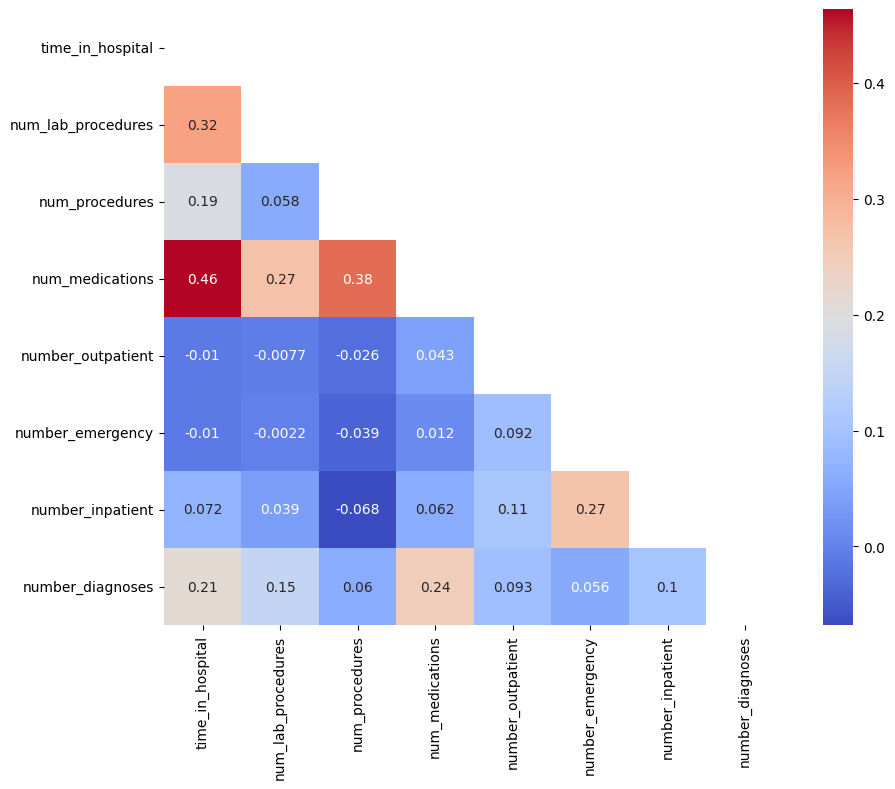

In [786]:
corr = df_diabetes[var_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

Se genera matriz de correlación para determinar si existen relaciones altas entre variables numericas.
Se detecta que hay una correlación de 0.47 entre "num_medications" y "time_in_hospital" pero se decide avanzar con ambas variables. Se tendrá en cuenta este hecho en caso de que afecte a la performance del modelo.

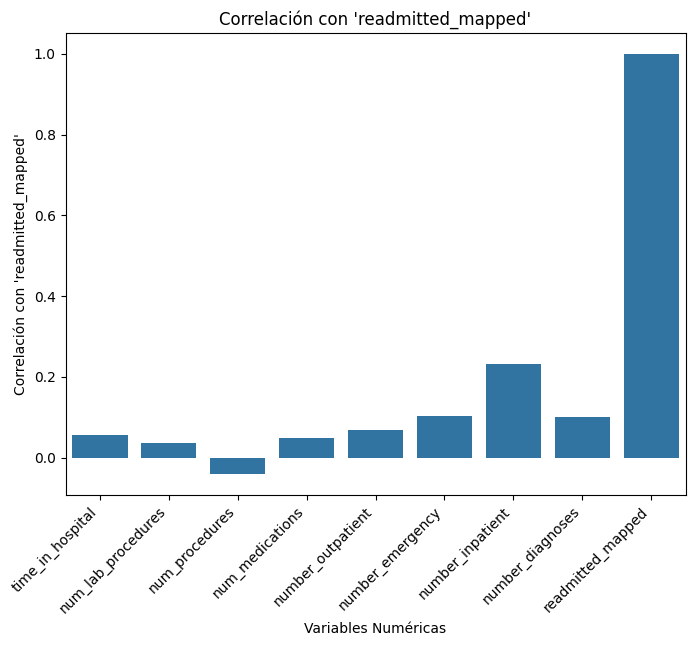

In [787]:
df_numeric = df_diabetes[var_numericas].select_dtypes(include=['int64', 'float64'])
df_numeric['readmitted_mapped'] = df_diabetes['readmitted_mapped']
correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

correlation_with_readmitted = df_numeric.corr()['readmitted_mapped']

plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_readmitted.index, y=correlation_with_readmitted.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Variables Numéricas")
plt.ylabel("Correlación con 'readmitted_mapped'")
plt.title("Correlación con 'readmitted_mapped'")
plt.show()

In [788]:
sorted_correlation = correlation_with_readmitted.sort_values(ascending=False)

print("Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):")
print(sorted_correlation)

Correlación con 'readmitted_mapped' (ordenadas de mayor a menor):
readmitted_mapped     1.000000
number_inpatient      0.232411
number_emergency      0.102278
number_diagnoses      0.099363
number_outpatient     0.067657
time_in_hospital      0.055545
num_medications       0.048328
num_lab_procedures    0.036606
num_procedures       -0.040165
Name: readmitted_mapped, dtype: float64


Se analiza que variables numericas tienen mas correlacion con la variable a predecir.

### VARIABLES CATEGORICAS

##### Analisis *var_persona*

In [789]:
var_persona = ['race', 'gender', 'age']

In [790]:
df_diabetes['race'].value_counts(normalize=True)

race
Caucasian          0.770819
AfricanAmerican    0.188350
Hispanic           0.019792
Other              0.014804
Asian              0.006235
Name: proportion, dtype: float64

In [791]:
df_diabetes['gender'].value_counts(normalize=True)

gender
Female             0.537908
Male               0.462063
Unknown/Invalid    0.000030
Name: proportion, dtype: float64

In [792]:
count_unknown_invalid = df_diabetes['gender'].value_counts().get('Unknown/Invalid', 0)
print(count_unknown_invalid)

3


Se elimina la row 'Unknown/Invalid' ya que no aporta información y son solamente 3 datos.

In [793]:
df_diabetes = df_diabetes.drop(df_diabetes[df_diabetes['gender'] == 'Unknown/Invalid'].index)

In [794]:
df_diabetes['gender'].value_counts(normalize=True)

gender
Female    0.537924
Male      0.462076
Name: proportion, dtype: float64

In [795]:
df_diabetes['age'].value_counts(normalize=True)

age
[70-80)     0.258337
[60-70)     0.222334
[80-90)     0.170489
[50-60)     0.170030
[40-50)     0.094512
[30-40)     0.036073
[90-100)    0.027783
[20-30)     0.015114
[10-20)     0.004679
[0-10)      0.000648
Name: proportion, dtype: float64

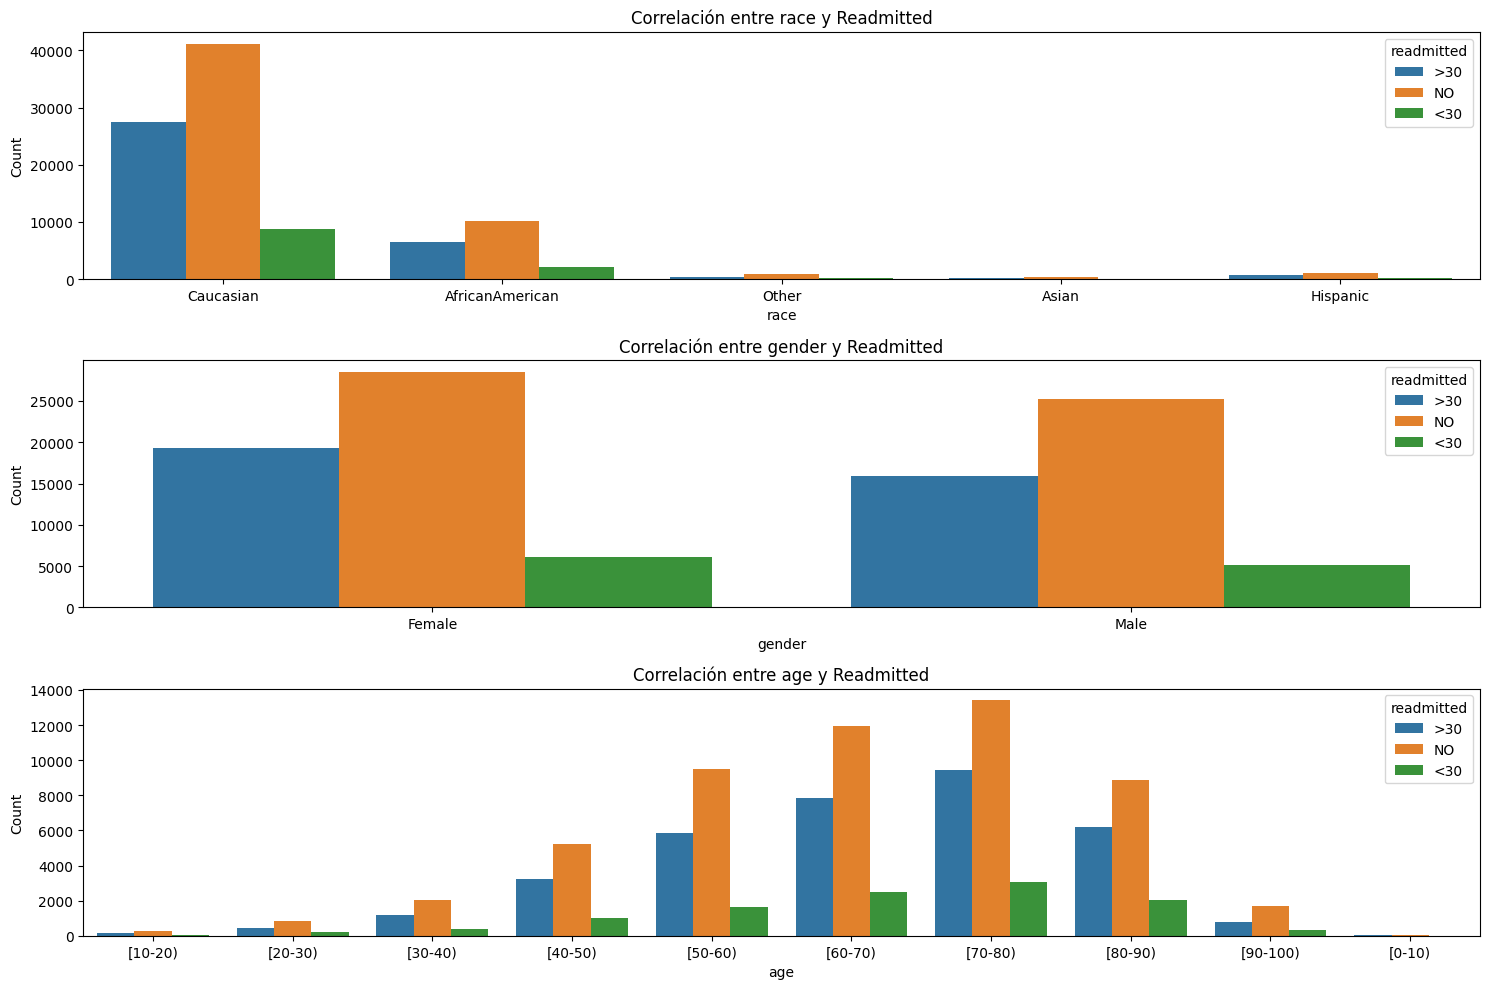

In [796]:
plt.figure(figsize=(15, 10))

for var in var_persona:
    plt.subplot(3, 1, var_persona.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)  # Ajuste: dodge=True
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

##### Analisis *var_medicas*

In [797]:
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']

In [798]:
df_diabetes['admission_type_id'].value_counts(normalize=True)

admission_type_id
1    0.531020
3    0.184994
2    0.181592
6    0.051865
5    0.047077
8    0.003142
7    0.000209
4    0.000100
Name: proportion, dtype: float64

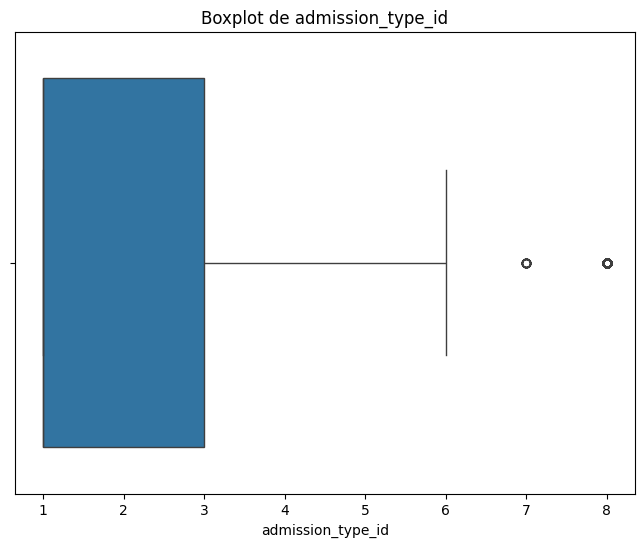

Valores atípicos de admission_type_id:
[8 7]


In [799]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes['admission_type_id'])
plt.title('Boxplot de admission_type_id')
plt.show()

Q1 = df_diabetes['admission_type_id'].quantile(0.25)
Q3 = df_diabetes['admission_type_id'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes[(df_diabetes['admission_type_id'] < lower_limit) | (df_diabetes['admission_type_id'] > upper_limit)]

print("Valores atípicos de admission_type_id:")
print(outliers['admission_type_id'].unique())

In [800]:
df_diabetes = df_diabetes.drop(df_diabetes[df_diabetes['admission_type_id'] == 7].index)
df_diabetes = df_diabetes.drop(df_diabetes[df_diabetes['admission_type_id'] == 4].index)

Se decide eliminar los outliers de la variable 'admission_type_id'

In [801]:
df_diabetes['discharge_disposition_id'].value_counts(normalize=True)

discharge_disposition_id
1     0.588684
3     0.138619
6     0.127961
18    0.036344
2     0.021096
22    0.019739
11    0.016336
5     0.011646
25    0.009540
4     0.008033
7     0.006027
23    0.004051
13    0.003972
14    0.003702
28    0.001377
8     0.001068
15    0.000629
24    0.000479
9     0.000210
17    0.000140
16    0.000110
19    0.000080
10    0.000060
27    0.000050
12    0.000030
20    0.000020
Name: proportion, dtype: float64

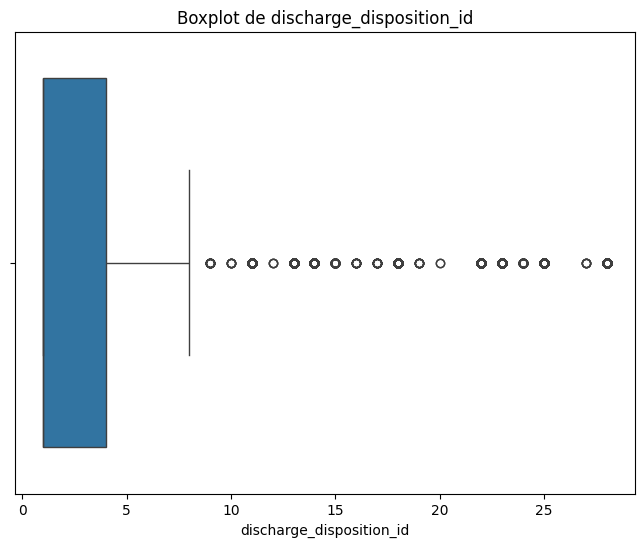

In [802]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes['discharge_disposition_id'])
plt.title('Boxplot de discharge_disposition_id')
plt.show()

Q1 = df_diabetes['discharge_disposition_id'].quantile(0.25)
Q3 = df_diabetes['discharge_disposition_id'].quantile(0.85)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes[(df_diabetes['discharge_disposition_id'] < lower_limit) | (df_diabetes['discharge_disposition_id'] > upper_limit)]

In [803]:
outliers.shape[0]

7642

Se dan de baja las variables con menos de 0.1% de ocurrencia

In [804]:
values_to_drop = df_diabetes['discharge_disposition_id'].value_counts(normalize=True)[df_diabetes['discharge_disposition_id'].value_counts(normalize=True) < 0.001].index

df_diabetes = df_diabetes[~df_diabetes['discharge_disposition_id'].isin(values_to_drop)]


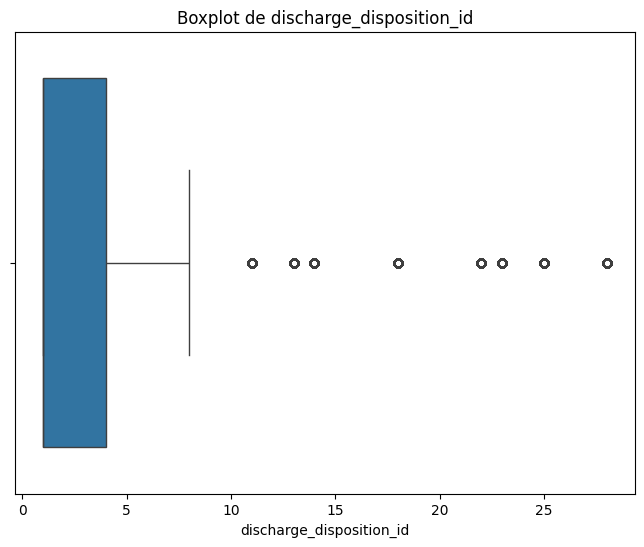

In [805]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes['discharge_disposition_id'])
plt.title('Boxplot de discharge_disposition_id')
plt.show()

Q1 = df_diabetes['discharge_disposition_id'].quantile(0.25)
Q3 = df_diabetes['discharge_disposition_id'].quantile(0.85)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_diabetes[(df_diabetes['discharge_disposition_id'] < lower_limit) | (df_diabetes['discharge_disposition_id'] > upper_limit)]

In [806]:
outliers.shape[0]

7491

In [807]:
df_diabetes['admission_source_id'].value_counts(normalize=True)

admission_source_id
7     0.566836
1     0.289496
17    0.066551
4     0.031381
6     0.021434
2     0.010877
5     0.008498
3     0.001789
20    0.001610
9     0.001120
8     0.000150
22    0.000120
10    0.000080
11    0.000020
25    0.000020
14    0.000010
13    0.000010
Name: proportion, dtype: float64

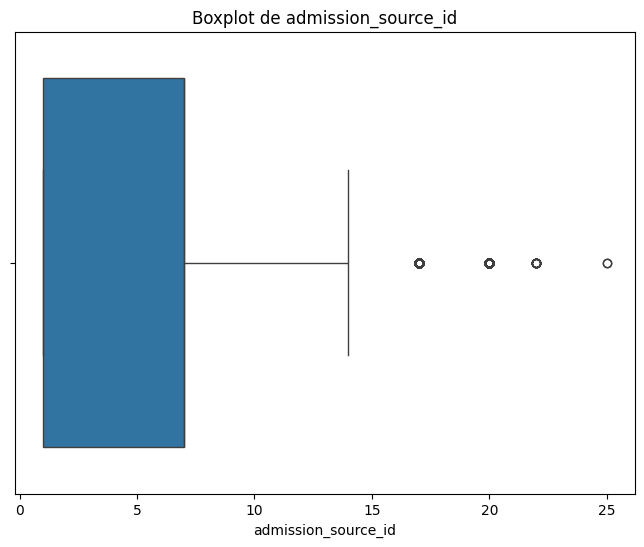

In [808]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes['admission_source_id'])
plt.title('Boxplot de admission_source_id')
plt.show()

Q1 = df_diabetes['admission_source_id'].quantile(0.25)
Q3 = df_diabetes['admission_source_id'].quantile(0.85)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_adm = df_diabetes[(df_diabetes['admission_source_id'] < lower_limit) | (df_diabetes['admission_source_id'] > upper_limit)]

In [809]:
outliers_adm.shape[0]

6832

In [810]:
df_diabetes['diag_1'].value_counts(normalize=True)

diag_1
428    0.068390
414    0.065411
786    0.039738
410    0.036070
486    0.034790
         ...   
216    0.000010
V43    0.000010
838    0.000010
955    0.000010
V51    0.000010
Name: proportion, Length: 714, dtype: float64

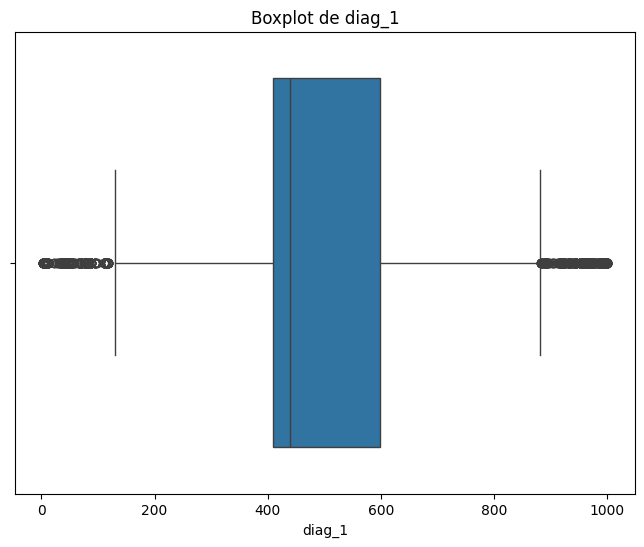

Valores atípicos de diag_1:
[]


In [811]:
df_diabetes_numeric = pd.DataFrame()
df_diabetes_numeric['diag_1'] = pd.to_numeric(df_diabetes['diag_1'], errors='coerce')


df_diabetes_numeric = df_diabetes_numeric.dropna(subset=['diag_1'])

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_1'])
plt.title('Boxplot de diag_1')
plt.show()

Q1 = df_diabetes_numeric['diag_1'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_1'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag1 = df_diabetes_numeric[(df_diabetes_numeric['diag_1'] < lower_limit) | (df_diabetes_numeric['diag_1'] > upper_limit)]

print("Valores atípicos de diag_1:")
print(outliers_diag1['diag_1'].unique())

In [812]:
len(outliers_diag1)

0

In [813]:
df_diabetes['diag_2'].value_counts(normalize=True)

diag_2
428     0.066381
276     0.066061
250     0.055794
427     0.050095
401     0.036999
          ...   
944     0.000010
E919    0.000010
E829    0.000010
953     0.000010
927     0.000010
Name: proportion, Length: 742, dtype: float64

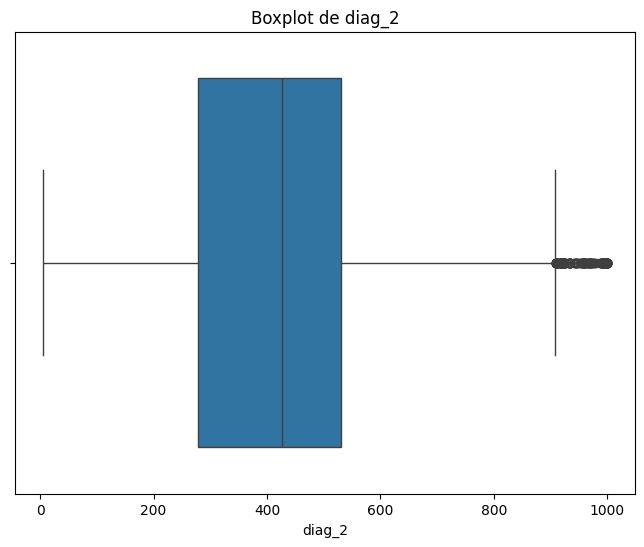

Valores atípicos de diag_2:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '625' '571' '250.42' '807'
 '250.13' '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995'
 '235' '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281'
 '250.33' '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648'
 '566' '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202'
 '493' '280' '225' '789' '154' '250.22' '441' '250.81' '962' '592' '707'
 '728' '618' '426' '569' '388' '386' '337' '82' '531' '812' '596' '784'
 'V58' '656' '433' '573' '492' '808' '958' '196' '112' '823' '532' '346'
 '162' '453' '535' '250' '595' '211' '303' '218' '782' '540' '189' '285'
 '198' '304' '157' '537' '250.31' '250.23' 'V57' '805' '507' '934' '376'
 '413' '153' '293' '626' '553' '4

In [814]:
df_diabetes_numeric['diag_2'] = pd.to_numeric(df_diabetes['diag_2'], errors='coerce')

df_diabetes_numeric = df_diabetes_numeric.dropna(subset=['diag_2'])

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_2'])
plt.title('Boxplot de diag_2')
plt.show()

Q1 = df_diabetes_numeric['diag_2'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_2'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag2 = df_diabetes_numeric[(df_diabetes_numeric['diag_2'] < lower_limit) | (df_diabetes_numeric['diag_2'] > upper_limit)]

print("Valores atípicos de diag_2:")
print(outliers['diag_1'].unique())


In [815]:
len(outliers_diag2)

0

In [816]:
df_diabetes['diag_3'].value_counts(normalize=True)

diag_3
250     0.115097
401     0.082696
276     0.051585
428     0.045607
427     0.039369
          ...   
853     0.000010
E945    0.000010
542     0.000010
E815    0.000010
971     0.000010
Name: proportion, Length: 789, dtype: float64

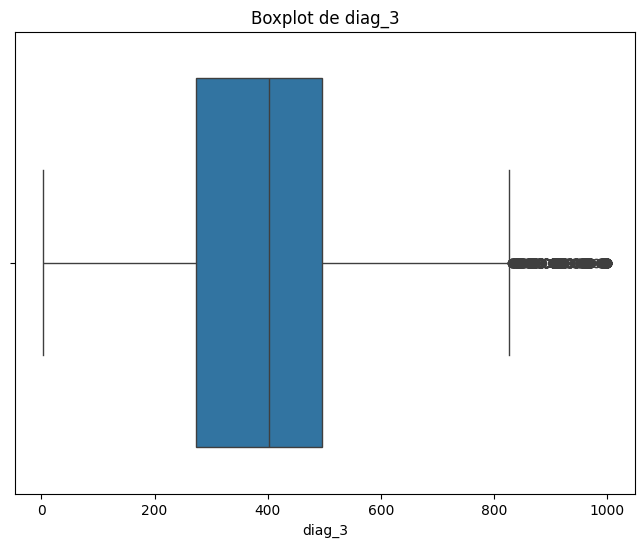

Valores atípicos de diag_3:
['440' '410' '428' '578' '250.6' '250.4' '250.32' '255' '997' '558' '599'
 '250.7' '402' '486' '414' '584' '682' '244' '250.03' '574' '577' '730'
 '786' '824' '562' '291' '276' '510' '401' '263' '434' '295' '438' '511'
 '427' '70' '722' '560' '182' '642' '491' '625' '571' '250.42' '807'
 '250.13' '456' '518' '572' '575' '250.02' '820' '515' '780' '996' '995'
 '235' '250.8' '250.82' '721' '787' '724' '282' '250.83' 'V55' '281'
 '250.33' '530' '466' '296' '250.12' '998' '590' '715' 'V53' '593' '648'
 '566' '822' '191' '557' '432' '38' '435' '733' '403' '455' '482' '202'
 '493' '280' '225' '789' '154' '250.22' '441' '250.81' '962' '592' '707'
 '728' '618' '426' '569' '388' '386' '337' '82' '531' '812' '596' '784'
 'V58' '656' '433' '573' '492' '808' '958' '196' '112' '823' '532' '346'
 '162' '453' '535' '250' '595' '211' '303' '218' '782' '540' '189' '285'
 '198' '304' '157' '537' '250.31' '250.23' 'V57' '805' '507' '934' '376'
 '413' '153' '293' '626' '553' '4

In [817]:
df_diabetes_numeric['diag_3'] = pd.to_numeric(df_diabetes['diag_3'], errors='coerce')

df_diabetes_numeric = df_diabetes_numeric.dropna(subset=['diag_3'])

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_diabetes_numeric['diag_3'])
plt.title('Boxplot de diag_3')
plt.show()

Q1 = df_diabetes_numeric['diag_3'].quantile(0.20)
Q3 = df_diabetes_numeric['diag_3'].quantile(0.80)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_diag3 = df_diabetes_numeric[(df_diabetes_numeric['diag_3'] < lower_limit) | (df_diabetes_numeric['diag_3'] > upper_limit)]

print("Valores atípicos de diag_3:")
print(outliers['diag_1'].unique())

In [818]:
len(outliers_diag3)

0

In [819]:
print(len(df_diabetes))

100029


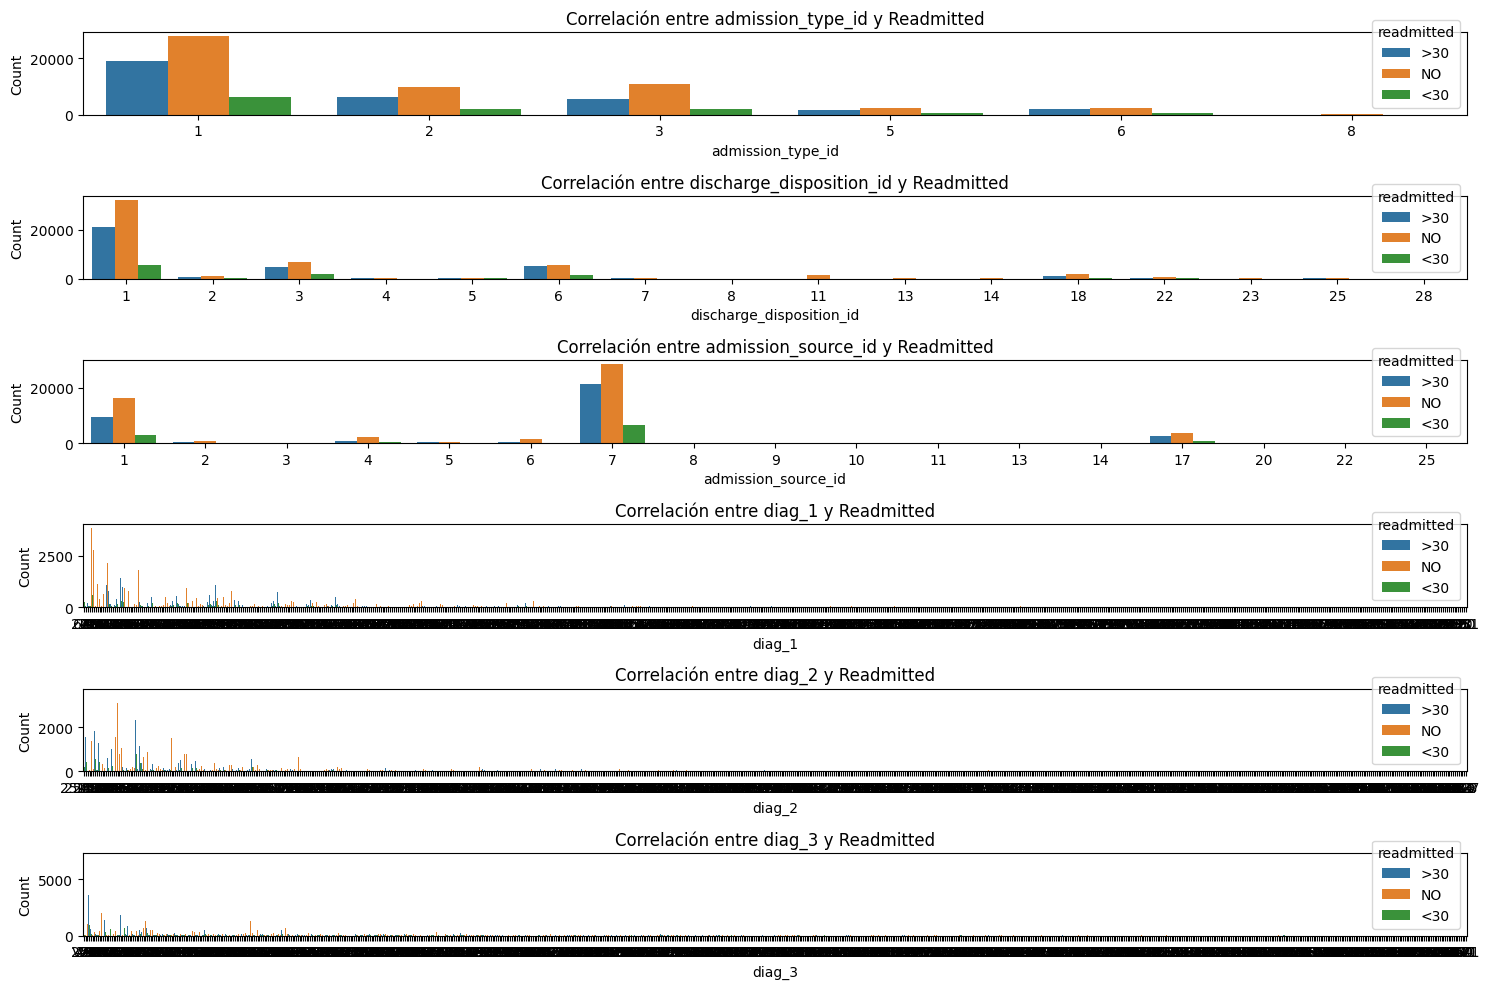

In [820]:
plt.figure(figsize=(15, 10))

for var in var_medicas:
    plt.subplot(6, 1, var_medicas.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted')
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

##### Analisis *var_medicine*

In [821]:
var_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

In [822]:
df_diabetes['metformin'].value_counts(normalize=True)

metformin
No        0.803497
Steady    0.180458
Up        0.010437
Down      0.005608
Name: proportion, dtype: float64

In [823]:
df_diabetes['repaglinide'].value_counts(normalize=True)

repaglinide
No        0.984674
Steady    0.013796
Up        0.001080
Down      0.000450
Name: proportion, dtype: float64

In [824]:
df_diabetes['nateglinide'].value_counts(normalize=True)

nateglinide
No        0.993032
Steady    0.006618
Up        0.000240
Down      0.000110
Name: proportion, dtype: float64

In [825]:
df_diabetes['chlorpropamide'].value_counts(normalize=True)

chlorpropamide
No        0.99917
Steady    0.00076
Up        0.00006
Down      0.00001
Name: proportion, dtype: float64

In [826]:
df_diabetes['glimepiride'].value_counts(normalize=True)

glimepiride
No        0.948695
Steady    0.046177
Up        0.003209
Down      0.001919
Name: proportion, dtype: float64

In [827]:
df_diabetes['acetohexamide'].value_counts(normalize=True)

acetohexamide
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64

In [828]:
df_diabetes['acetohexamide'].value_counts(normalize=False)

acetohexamide
No        100028
Steady         1
Name: count, dtype: int64

Se decide quitar la variable 'acetohexamide' por la naturaleza de sus datos.

In [829]:
df_diabetes = df_diabetes.drop(['acetohexamide'],axis=1)

In [830]:
df_diabetes['glipizide'].value_counts(normalize=True)

glipizide
No        0.874606
Steady    0.112157
Up        0.007668
Down      0.005568
Name: proportion, dtype: float64

In [831]:
df_diabetes['glyburide'].value_counts(normalize=True)

glyburide
No        0.895000
Steady    0.091374
Up        0.008068
Down      0.005558
Name: proportion, dtype: float64

In [832]:
df_diabetes['tolbutamide'].value_counts(normalize=False)

tolbutamide
No        100006
Steady        23
Name: count, dtype: int64

In [833]:
df_diabetes['pioglitazone'].value_counts(normalize=False)

pioglitazone
No        92803
Steady     6879
Up          231
Down        116
Name: count, dtype: int64

In [834]:
df_diabetes['rosiglitazone'].value_counts(normalize=False)

rosiglitazone
No        93740
Steady     6025
Up          177
Down         87
Name: count, dtype: int64

In [835]:
df_diabetes['acarbose'].value_counts(normalize=False)

acarbose
No        99724
Steady      292
Up           10
Down          3
Name: count, dtype: int64

In [836]:
df_diabetes['miglitol'].value_counts(normalize=False)

miglitol
No        99992
Steady       31
Down          4
Up            2
Name: count, dtype: int64

In [837]:
df_diabetes['troglitazone'].value_counts(normalize=False)

troglitazone
No        100026
Steady         3
Name: count, dtype: int64

In [838]:
df_diabetes['tolazamide'].value_counts(normalize=False)

tolazamide
No        99992
Steady       36
Up            1
Name: count, dtype: int64

In [839]:
df_diabetes['examide'].value_counts(normalize=False)

examide
No    100029
Name: count, dtype: int64

In [840]:
df_diabetes['citoglipton'].value_counts(normalize=False)

citoglipton
No    100029
Name: count, dtype: int64

In [841]:
df_diabetes['insulin'].value_counts(normalize=False)

insulin
No        46716
Steady    30196
Down      11991
Up        11126
Name: count, dtype: int64

In [842]:
df_diabetes['glyburide-metformin'].value_counts(normalize=False)

glyburide-metformin
No        99335
Steady      680
Up            8
Down          6
Name: count, dtype: int64

In [843]:
df_diabetes['glimepiride-pioglitazone'].value_counts(normalize=False)

glimepiride-pioglitazone
No        100028
Steady         1
Name: count, dtype: int64

In [844]:
df_diabetes['metformin-rosiglitazone'].value_counts(normalize=False)

metformin-rosiglitazone
No        100027
Steady         2
Name: count, dtype: int64

In [845]:
df_diabetes['metformin-pioglitazone'].value_counts(normalize=False)

metformin-pioglitazone
No        100028
Steady         1
Name: count, dtype: int64

In [846]:
df_diabetes['change'].value_counts(normalize=False)

change
No    53777
Ch    46252
Name: count, dtype: int64

In [847]:
df_diabetes['diabetesMed'].value_counts(normalize=False)

diabetesMed
Yes    76983
No     23046
Name: count, dtype: int64

In [848]:
print(len(var_medicine))

25


In [849]:
var_medicine1 = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose']
var_medicine2 = [ 'miglitol', 'troglitazone', 'tolazamide', 'examide',
                'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

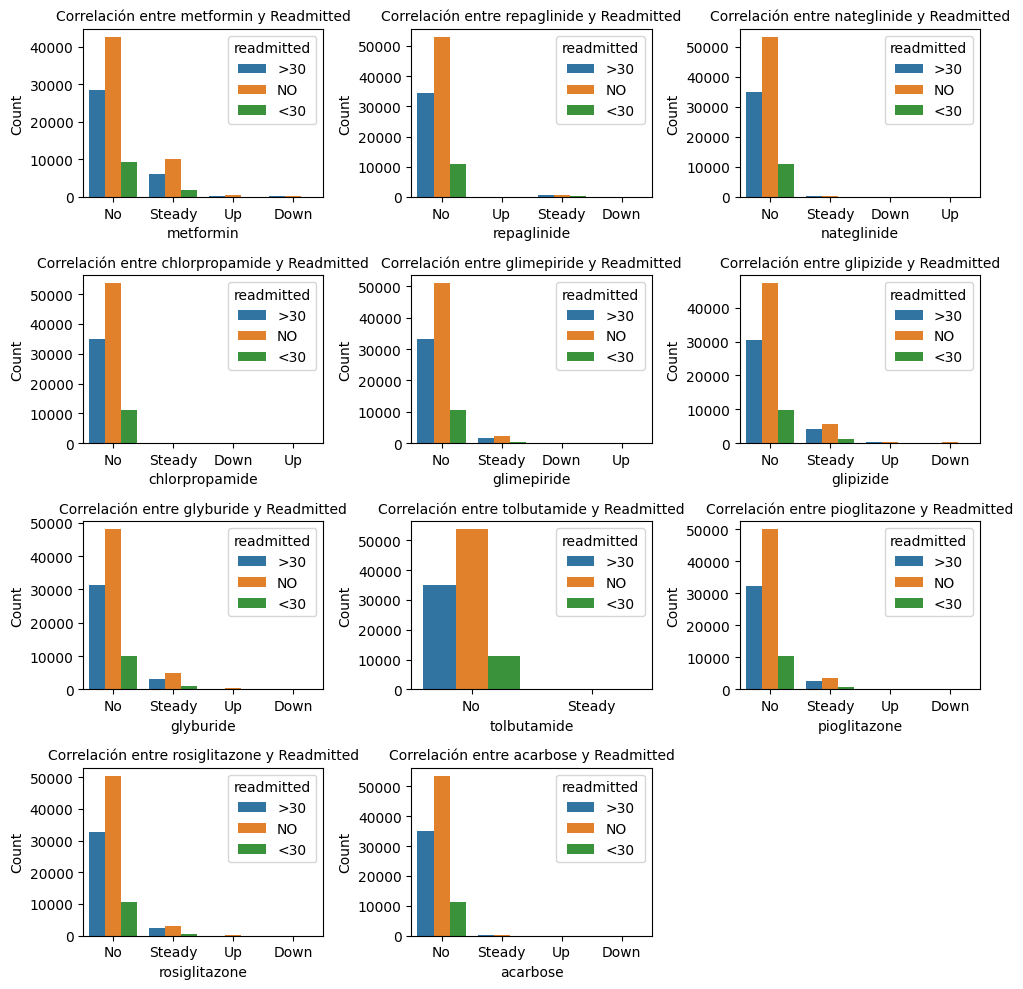

In [850]:
plt.figure(figsize=(10, 10))

for var in var_medicine1:
    plt.subplot(4, 3, var_medicine1.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted', fontsize=10)
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


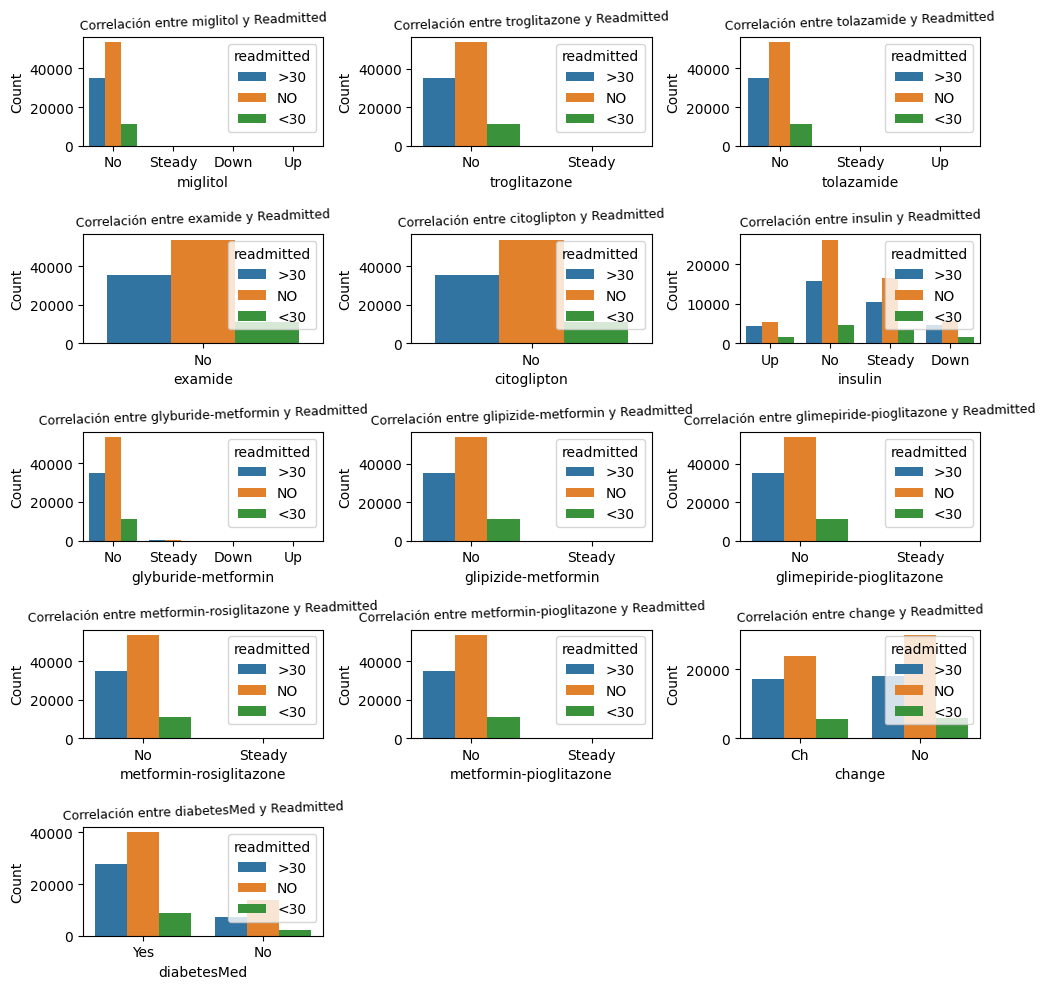

In [851]:
plt.figure(figsize=(10, 10))

for var in var_medicine2:
    plt.subplot(5, 3, var_medicine2.index(var) + 1)
    sns.countplot(x=var, hue='readmitted', data=df_diabetes, dodge=True)
    plt.title(f'Correlación entre {var} y Readmitted', fontsize=9, rotation=2)
    plt.xlabel(var)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Análisis de la Variable Objetivo

In [852]:
print(len(df_diabetes))

100029


#### Previamente se realizó el mapeo de la variable objetivo de la siguiente forma:

readmitted_mapping = {'NO': 1, '>30': 2, '<30': 3}

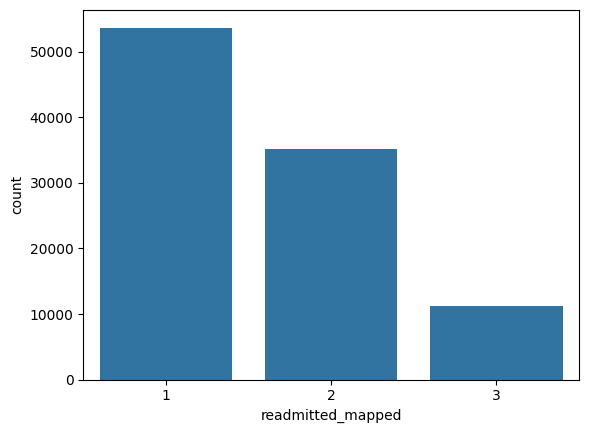

In [853]:
sns.countplot(x='readmitted_mapped', data=df_diabetes)
plt.show()

In [854]:
value_counts_result = df_diabetes['readmitted'].value_counts()
print(value_counts_result)

readmitted
NO     53707
>30    35119
<30    11203
Name: count, dtype: int64


In [855]:
scaler = StandardScaler()

df_diabetes[var_numericas] = scaler.fit_transform(df_diabetes[var_numericas])

print(df_diabetes[var_numericas].head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1         -0.474424            0.803455       -0.789447         0.231756   
2         -0.808744           -1.634063        2.132574        -0.384188   
3         -0.808744            0.041730       -0.205043        -0.014622   
4         -1.143065            0.397202       -0.789447        -1.000132   
5         -0.474424           -0.618431        2.716979        -0.014622   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
1          -0.292392         -0.212961         -0.506217          0.817320  
2           1.278291         -0.212961          0.285756         -0.813294  
3          -0.292392         -0.212961         -0.506217         -0.269756  
4          -0.292392         -0.212961         -0.506217         -1.356832  
5          -0.292392         -0.212961         -0.506217          0.817320  


In [856]:
df_diabetes[var_persona].info()

<class 'pandas.core.frame.DataFrame'>
Index: 100029 entries, 1 to 101765
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   race    100029 non-null  object
 1   gender  100029 non-null  object
 2   age     100029 non-null  object
dtypes: object(3)
memory usage: 5.1+ MB


#### SELECCION DE FEATURES

In [858]:
var_persona = ['race', 'gender', 'age']
var_numericas = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                'num_medications', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'number_diagnoses']
var_medicas = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

var_objetivo = ['readmitted_mapped']

df_features = df_diabetes[var_persona + var_numericas + var_medicas + var_objetivo ].copy()

df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100029 entries, 1 to 101765
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   race                      100029 non-null  object 
 1   gender                    100029 non-null  object 
 2   age                       100029 non-null  object 
 3   time_in_hospital          100029 non-null  float64
 4   num_lab_procedures        100029 non-null  float64
 5   num_procedures            100029 non-null  float64
 6   num_medications           100029 non-null  float64
 7   number_outpatient         100029 non-null  float64
 8   number_emergency          100029 non-null  float64
 9   number_inpatient          100029 non-null  float64
 10  number_diagnoses          100029 non-null  float64
 11  admission_type_id         100029 non-null  int64  
 12  discharge_disposition_id  100029 non-null  int64  
 13  admission_source_id       100029 non-null  int64 

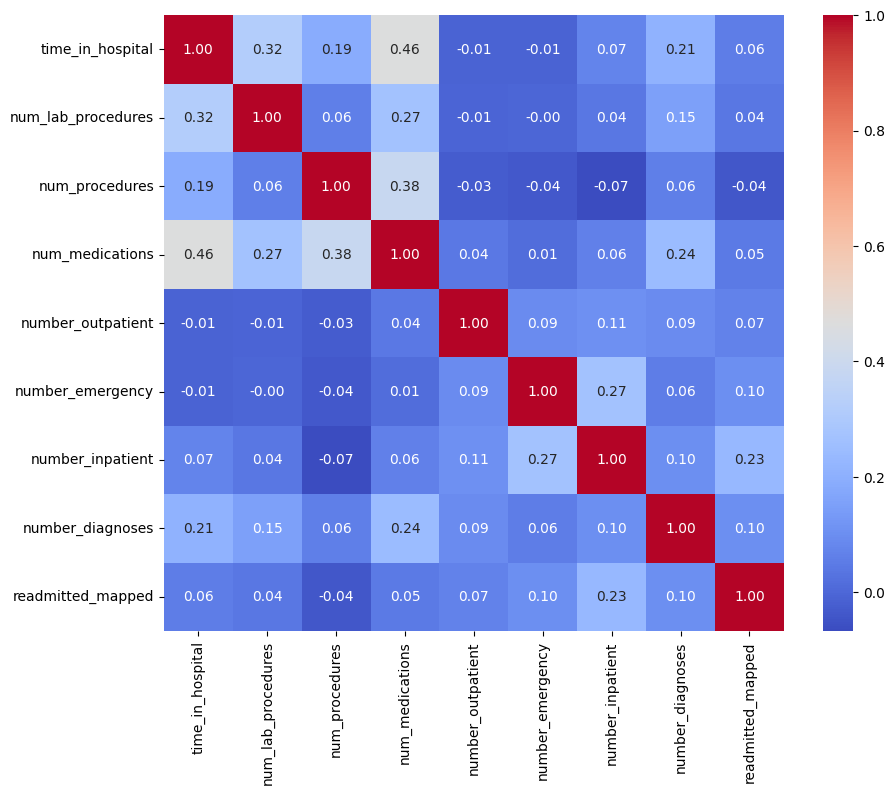

In [859]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_features[var_numericas + var_objetivo].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


##### ONE HOT ENCODING

Se aplica One Hot Encoding a las variables relacionadas a las personas.

In [860]:
df_features = pd.get_dummies(df_features, columns=var_medicas)

In [861]:
df_features = pd.get_dummies(df_features, columns=var_persona)

df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100029 entries, 1 to 101765
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   time_in_hospital             100029 non-null  float64
 1   num_lab_procedures           100029 non-null  float64
 2   num_procedures               100029 non-null  float64
 3   num_medications              100029 non-null  float64
 4   number_outpatient            100029 non-null  float64
 5   number_emergency             100029 non-null  float64
 6   number_inpatient             100029 non-null  float64
 7   number_diagnoses             100029 non-null  float64
 8   readmitted_mapped            100029 non-null  int64  
 9   admission_type_id_1          100029 non-null  bool   
 10  admission_type_id_2          100029 non-null  bool   
 11  admission_type_id_3          100029 non-null  bool   
 12  admission_type_id_5          100029 non-null  bool   
 13  admi

##### STANDARD SCALER

Se aplica standard scaler para manejar una misma escala con todas las variables numericas

In [862]:
scaler = StandardScaler()

df_features[var_numericas] = scaler.fit_transform(df_features[var_numericas])

print(df_features[var_numericas].head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1         -0.474424            0.803455       -0.789447         0.231756   
2         -0.808744           -1.634063        2.132574        -0.384188   
3         -0.808744            0.041730       -0.205043        -0.014622   
4         -1.143065            0.397202       -0.789447        -1.000132   
5         -0.474424           -0.618431        2.716979        -0.014622   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
1          -0.292392         -0.212961         -0.506217          0.817320  
2           1.278291         -0.212961          0.285756         -0.813294  
3          -0.292392         -0.212961         -0.506217         -0.269756  
4          -0.292392         -0.212961         -0.506217         -1.356832  
5          -0.292392         -0.212961         -0.506217          0.817320  


In [864]:
from sklearn.model_selection import train_test_split

X = df_features.drop('readmitted_mapped', axis=1)
y = df_features['readmitted_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [463]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Matriz de Confusión:
[[9271 1467    0]
 [4702 2292    3]
 [1457  807    7]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.60      0.86      0.71     10738
           2       0.50      0.33      0.40      6997
           3       0.70      0.00      0.01      2271

    accuracy                           0.58     20006
   macro avg       0.60      0.40      0.37     20006
weighted avg       0.58      0.58      0.52     20006



In [865]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model_best_params = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

rf_model_best_params.fit(X_train, y_train)

y_pred_best_params = rf_model_best_params.predict(X_test)

print("Matriz de Confusión (con mejores hiperparámetros):")
print(confusion_matrix(y_test, y_pred_best_params))

print("\nReporte de Clasificación (con mejores hiperparámetros):")
print(classification_report(y_test, y_pred_best_params))


Matriz de Confusión (con mejores hiperparámetros):
[[9490 1248    0]
 [4868 2129    0]
 [1511  759    1]]

Reporte de Clasificación (con mejores hiperparámetros):
              precision    recall  f1-score   support

           1       0.60      0.88      0.71     10738
           2       0.51      0.30      0.38      6997
           3       1.00      0.00      0.00      2271

    accuracy                           0.58     20006
   macro avg       0.70      0.40      0.37     20006
weighted avg       0.61      0.58      0.52     20006



In [866]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_features.drop('readmitted_mapped', axis=1)
y = df_features['readmitted_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

num_lab_procedures        0.195022
num_medications           0.162590
time_in_hospital          0.114486
num_procedures            0.069713
number_diagnoses          0.066819
                            ...   
admission_source_id_10    0.000020
admission_source_id_25    0.000007
admission_source_id_13    0.000003
admission_source_id_11    0.000003
admission_source_id_14    0.000002
Length: 64, dtype: float64


In [876]:
feature_top = feature_importances[feature_importances > 0.03]

feature_top

num_lab_procedures    0.195022
num_medications       0.162590
time_in_hospital      0.114486
num_procedures        0.069713
number_diagnoses      0.066819
number_inpatient      0.053025
dtype: float64

In [888]:
feature_top = ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'num_procedures', 'number_diagnoses', 'number_inpatient']
feature_top_medicine = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
                        'pioglitazone', 'rosiglitazone', 'insulin']

In [889]:
df_features_top = df_diabetes[feature_top + feature_top_medicine + var_objetivo ].copy()

In [892]:
df_features_top = pd.get_dummies(df_features_top, columns=feature_top_medicine)

In [893]:
from sklearn.model_selection import train_test_split

X = df_features_top.drop('readmitted_mapped', axis=1)
y = df_features_top['readmitted_mapped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [894]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model_best_params = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

rf_model_best_params.fit(X_train, y_train)

y_pred_best_params = rf_model_best_params.predict(X_test)

print("Matriz de Confusión (con mejores hiperparámetros):")
print(confusion_matrix(y_test, y_pred_best_params))

print("\nReporte de Clasificación (con mejores hiperparámetros):")
print(classification_report(y_test, y_pred_best_params))


Matriz de Confusión (con mejores hiperparámetros):
[[9594 1144    0]
 [5265 1732    0]
 [1597  674    0]]

Reporte de Clasificación (con mejores hiperparámetros):
              precision    recall  f1-score   support

           1       0.58      0.89      0.71     10738
           2       0.49      0.25      0.33      6997
           3       0.00      0.00      0.00      2271

    accuracy                           0.57     20006
   macro avg       0.36      0.38      0.34     20006
weighted avg       0.48      0.57      0.49     20006



c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

sigue performando mal, voy a cambiar las features